In [25]:
import sys; sys.path.append("../../")
from DataPreprocessing.DataPreprocessing import *
from DataExploration import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

# Question:
    Predict sales of a game given release date, platform, publisher and developer



## 1- Expectations: 
    The model should determine the game characteristics through year,developed,publisher
    and platform that best predict that sales of a game.

## Read Data 

In [26]:
df = read_data(kind='dataset')
df = df.dropna()

## EDA

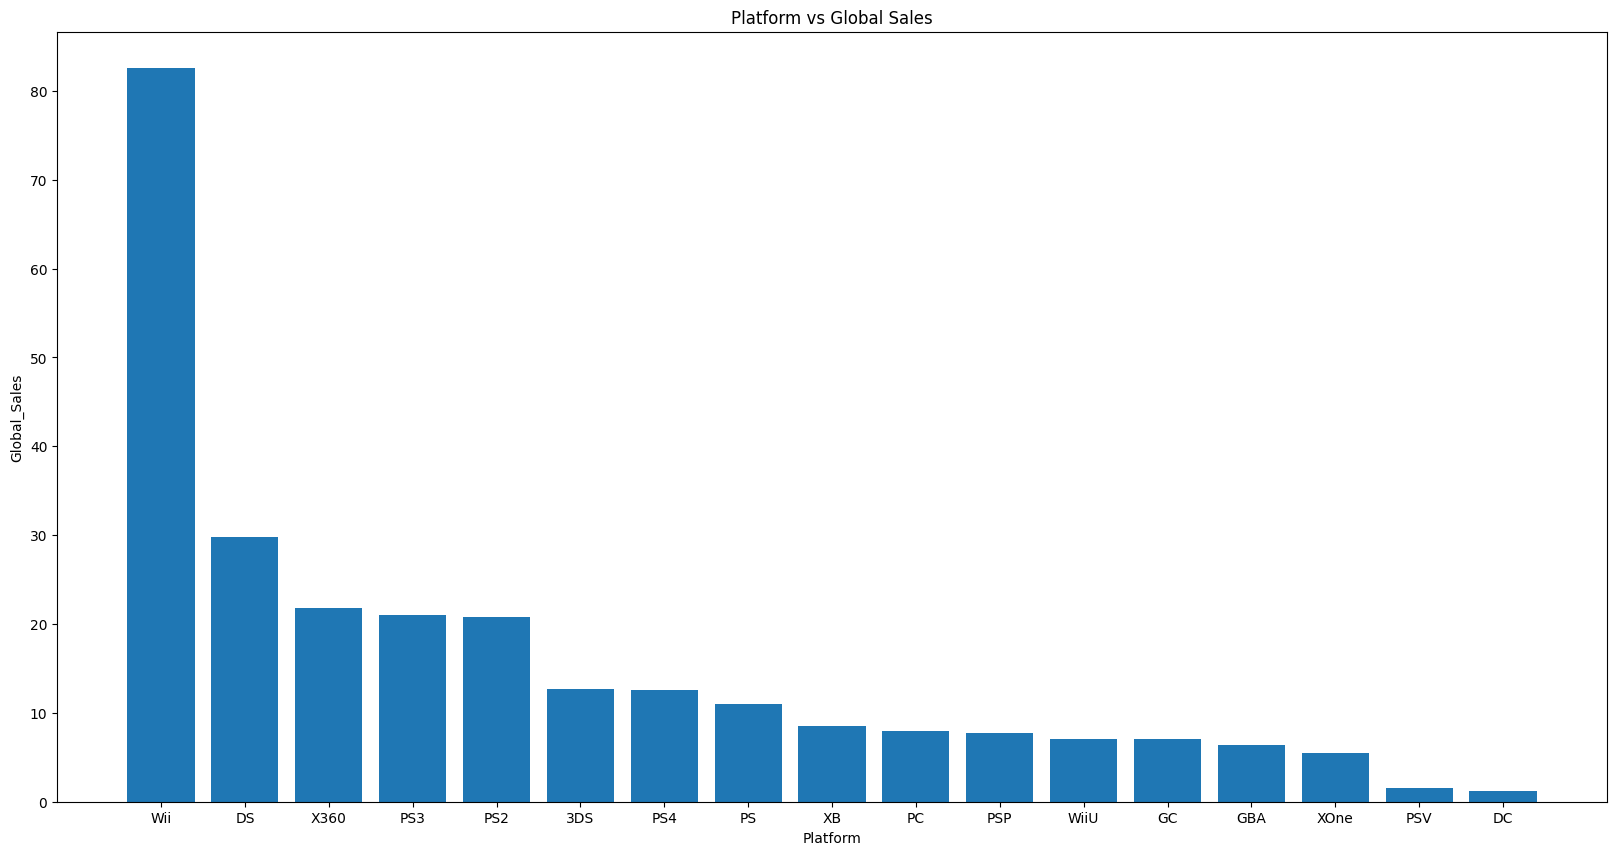

'from the below graph we see that platform with highest global sales is ????'

In [27]:
plot(df, 'Platform', 'Global_Sales', 'Platform vs Global Sales')
'''from the below graph we see that platform with highest global sales is ????'''

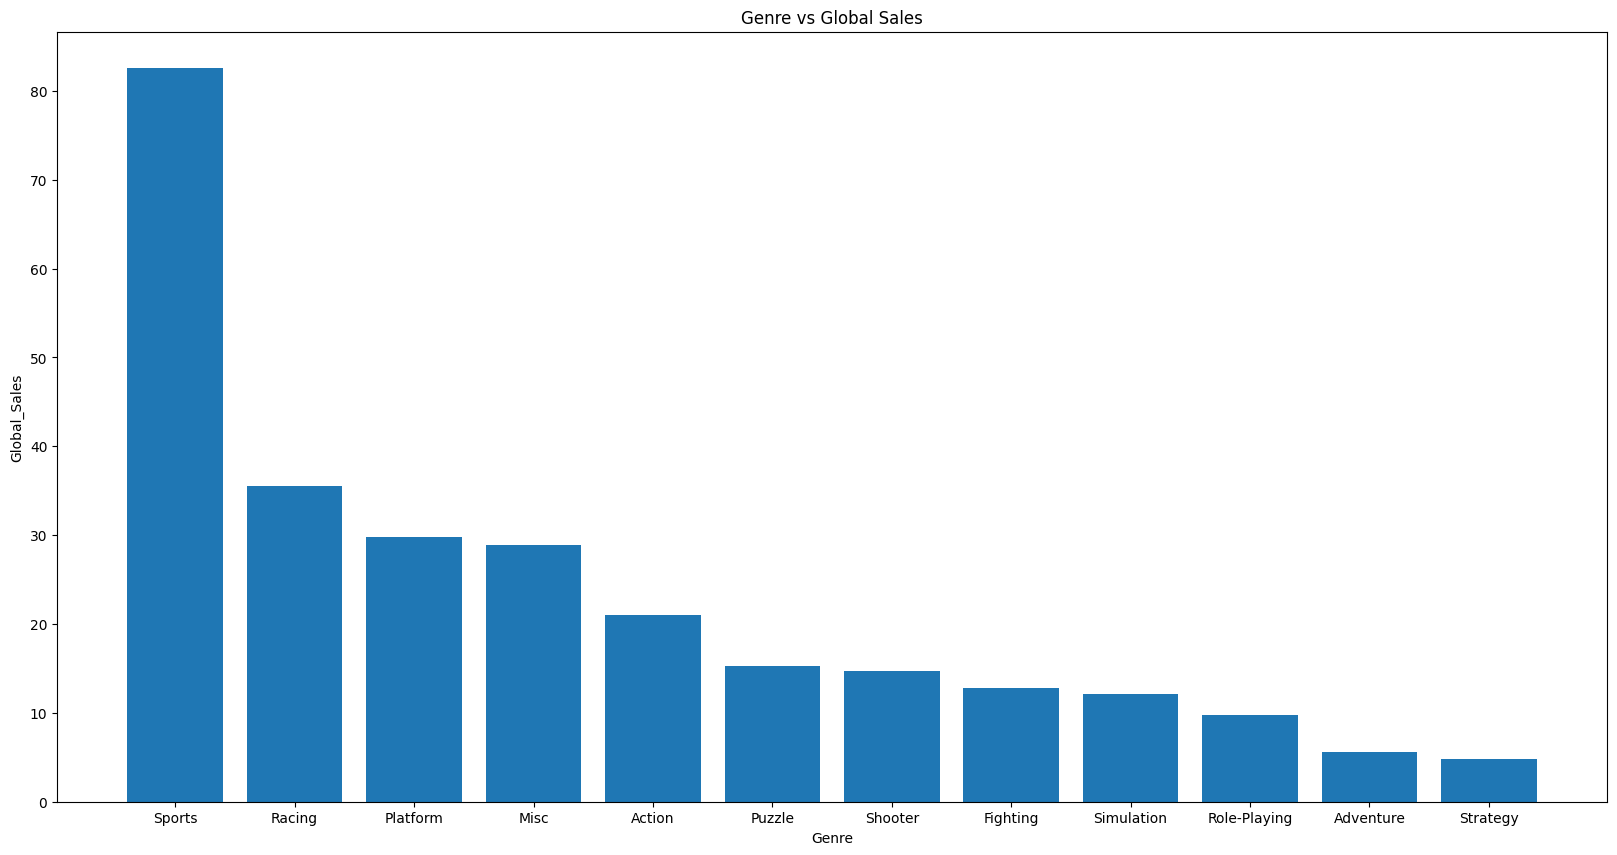

'from the below graph we see that global sales were highest for ?? genre'

In [28]:
plot(df, 'Genre', 'Global_Sales', 'Genre vs Global Sales')
'''from the below graph we see that global sales were highest for ?? genre'''

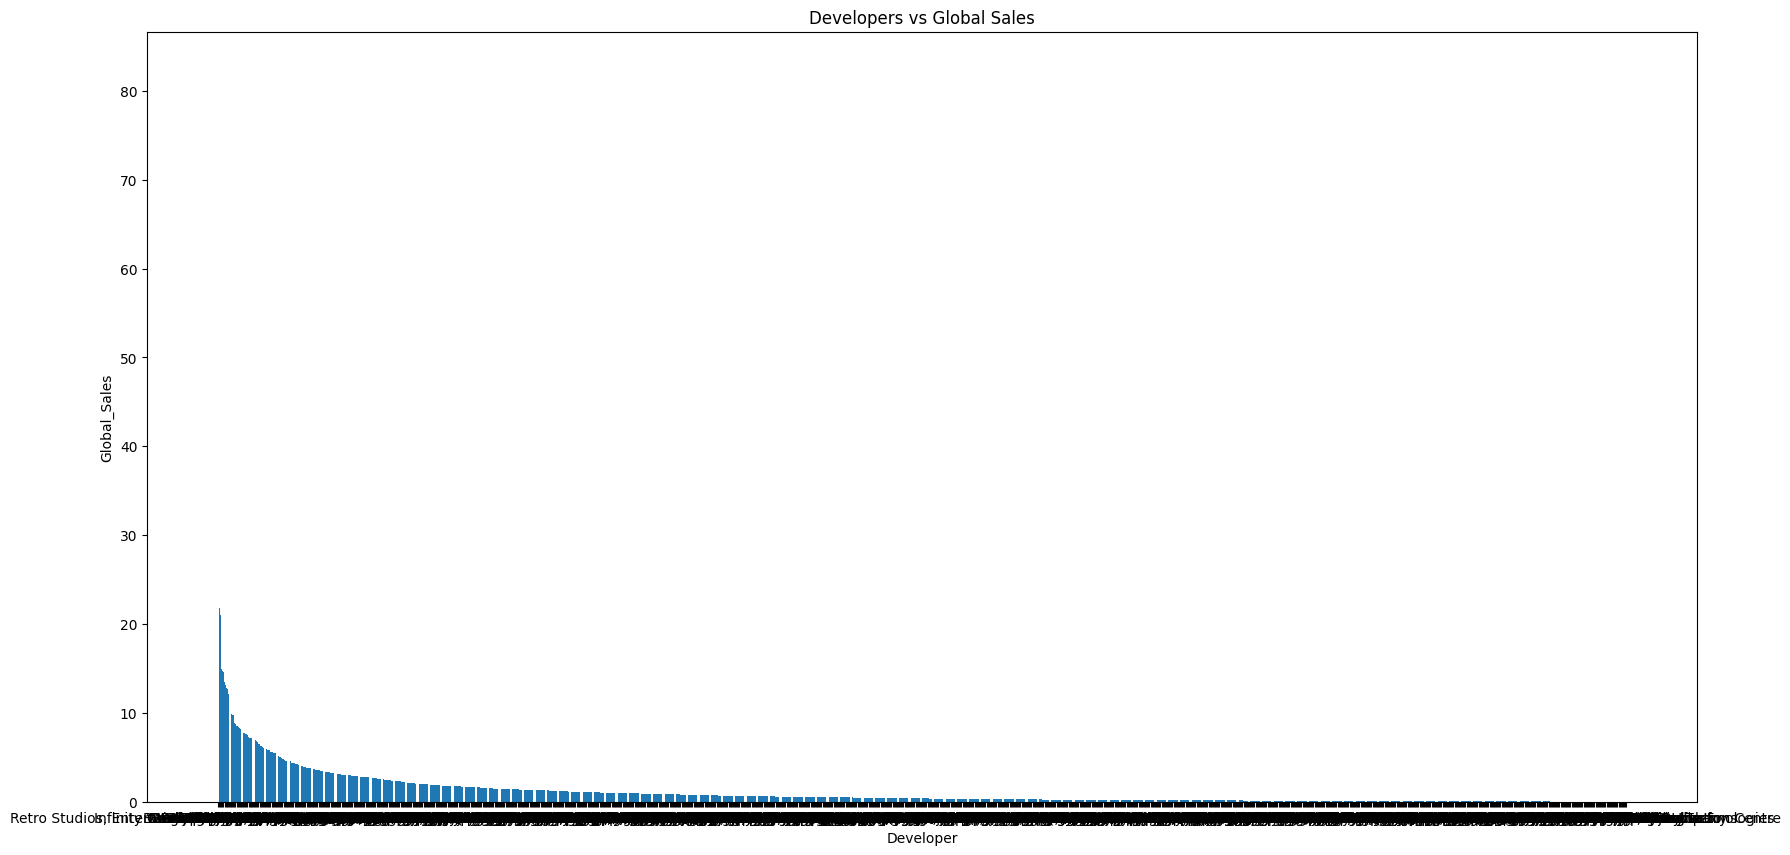

Developer
Nintendo    529.9
Name: Global_Sales, dtype: float64

In [29]:
plot(df, 'Developer', 'Global_Sales', 'Developers vs Global Sales')
# developer whose games have highest global sales is 
df.groupby('Developer')['Global_Sales'].sum().sort_values(ascending=False).head(1)

In [30]:
# get the genre with highest sales
df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(1)

Genre
Action    1203.16
Name: Global_Sales, dtype: float64

## Read as train and val data frames

In [31]:
# read the data
df_train = read_data(kind='train')
df_val = read_data(kind='val')
# keep only the columns release year, publisher, developer,and platform 
df_train = df_train[['Year_of_Release', 'Publisher', 'Developer', 'Platform','Genre', 'Global_Sales']]
df_val = df_val[['Year_of_Release', 'Publisher', 'Developer', 'Platform', 'Genre','Global_Sales']]
df_train.head()

,Year_of_Release,Publisher,Developer,Platform,Genre,Global_Sales
0,2011.0,Cave,NaN,X360,Shooter,0.06
1,2014.0,Namco Bandai Games,Ganbarion,WiiU,Action,0.06
2,2006.0,Konami Digital Entertainment,Kojima Productions,DS,Role-Playing,0.23
3,2010.0,Yeti,NaN,PSP,Adventure,0.01
4,2008.0,Ubisoft,Ubisoft Montreal,X360,Action,1.59


## Handle Missing values


In [32]:
# handle missing values using mode imputation
df_train =handle_missing_values(df_train, handling_method='mode',neighbors=5)
df_val =handle_missing_values(df_val,handling_method='mode',neighbors=5)
df_train.head()

Total Number of rows : 10031
Number of rows with missing values: 4121
Total Number of rows : 3344
Number of rows with missing values: 1353


,Year_of_Release,Publisher,Developer,Platform,Genre,Global_Sales
0,2011.0,Cave,Ubisoft,X360,Shooter,0.06
1,2014.0,Namco Bandai Games,Ganbarion,WiiU,Action,0.06
2,2006.0,Konami Digital Entertainment,Kojima Productions,DS,Role-Playing,0.23
3,2010.0,Yeti,Ubisoft,PSP,Adventure,0.01
4,2008.0,Ubisoft,Ubisoft Montreal,X360,Action,1.59


## prepare features and labels

In [33]:
y_train = df_train['Global_Sales']
X_train = df_train.drop('Global_Sales', axis=1)
y_val = df_val['Global_Sales']
X_val = df_val.drop('Global_Sales', axis=1)
X_train.head()


,Year_of_Release,Publisher,Developer,Platform,Genre
0,2011.0,Cave,Ubisoft,X360,Shooter
1,2014.0,Namco Bandai Games,Ganbarion,WiiU,Action
2,2006.0,Konami Digital Entertainment,Kojima Productions,DS,Role-Playing
3,2010.0,Yeti,Ubisoft,PSP,Adventure
4,2008.0,Ubisoft,Ubisoft Montreal,X360,Action


In [34]:
X_train.isnull().sum()  


Year_of_Release    0
Publisher          0
Developer          0
Platform           0
Genre              0
dtype: int64

# Models

## 1- catboost Model

In [35]:
# !pip install catboost

In [36]:
import catboost as cat
cat_feat =[ 'Publisher', 'Developer', 'Platform','Genre',]
model = cat.CatBoostRegressor(random_state=100,cat_features=cat_feat,verbose=0)
model.fit(X_train ,y_train)

### Model Accuracy

In [37]:
y_pred = model.predict(X_val)

In [38]:
rmse = sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

1.0046751594678969


In [39]:
print("R2 score =", round(sm.r2_score( y_val, y_pred), 2))


R2 score = 0.12


## Encoding for cat features for the coming models

In [40]:
X_train.head()
encoding(X_train)

,Year_of_Release,Publisher,Developer,Platform,Genre
0,2011.0,0.000698,0.410627,0.075167,0.077360
1,2014.0,0.054930,0.000299,0.008872,0.198684
2,2006.0,0.045559,0.000498,0.129798,0.090719
3,2010.0,0.000698,0.410627,0.069485,0.078257
4,2008.0,0.055428,0.005682,0.075167,0.198684
...,...,...,...,...,...
10026,2000.0,0.021932,0.000698,0.071877,0.198684
10027,2002.0,0.001894,0.000199,0.033297,0.075167
10028,2001.0,0.000698,0.000498,0.049048,0.052836
10029,2016.0,0.060413,0.002094,0.077958,0.052836


### 2- ElasticNet Model

In [41]:
regr = ElasticNet(alpha=0.1)
# Prepare input data (frequncy encoding)
regr.fit(encoding(X_train), y_train)

ElasticNet(alpha=0.1)

In [42]:
y_predicted =regr.predict(encoding(X_val))
print("R2 score =", round(sm.r2_score( y_val, y_predicted), 2))

R2 score = 0.01


### 3- Linear Regression Model

In [43]:
reg = LinearRegression().fit(X_train, y_train)

In [44]:
y_predicted =reg.predict(X_val)
# compute accuracy
print("R2 score =", round(sm.r2_score( y_val, y_predicted), 2))



R2 score = 0.05


## 3- Comparing Expectations to data:
       ???